In [1]:
# Packages
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.nn as jnn
import jax.numpy as jnp
from jax import random

import flax.linen as nn
from flax.training import train_state

import optax

In [38]:
data = np.array([0,1,2,3,4,5,6,7,8,9])      #       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
data[5]     # 5th position                          [5]
data[3:6]   # From 3rd to 5th position              [3, 4, 5]
data[:5]    # First 5                               [0, 1, 2, 3, 4]
data[5:]    # Without the first 5 (From 6th one)    [5, 6, 7, 8, 9]
data[-4]    # Fourth from behind                    [6]
data[::2]   # Every Second                          [0, 2, 4, 6, 8]
data[::-2]  # Every Second from behind              [9, 7, 5, 3, 1]
data[::-1]  # Reverse Order                         [9, 8, 7, 6, 5, 4, 3, 2, 1, 0]
np.dot([1,2,3], data[0:3][::-1])    #               Dot Product v^T * v

4

### AR(p) simulator

$X_t = c + \beta_1X_{t-1} + \beta_2X_{t-2} + ... + \beta_pX_{t-p} + \epsilon  \quad ,\epsilon \sim \mathcal{N}(0, \sigma^2)$

In [3]:
def sample_ar_process(n_samples, ar_params, noise_std = 1.0, initial_values = None):
    p = len(ar_params)

    if initial_values is None:
        initial_values = np.zeros(p)
    
    # Initial data with zero's
    data = np.zeros(n_samples)
    # First p values
    data[:p] = initial_values

    # Generate AR(p) process:
    for i in range(p, n_samples):
        noise = np.random.normal(0, noise_std)
        data[i] = np.dot(ar_params, data[i-p:i][::-1]) + noise
    return data
    

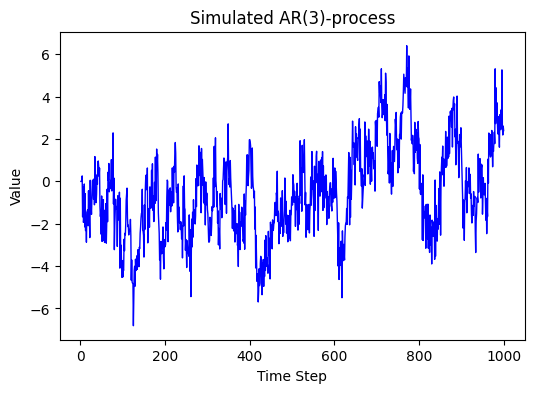

In [4]:
ar_data = sample_ar_process(n_samples = 1000, ar_params = np.array([0.33, 0.5, 0.1]))
ar_data = np.array([np.arange(1,len(ar_data)+1),ar_data])
plt.figure(figsize=(6,4))
plt.plot(ar_data[0], ar_data[1], linewidth = 1, color ='blue')
plt.title("Simulated AR(3)-process")
plt.ylabel("Value")
plt.xlabel("Time Step")
plt.show()

### SDE Simulator

$dX_t = a(X_t, t)dt + b(X_t, t)dW_t \\$

$a(X_t, t)$: Drift parameter $\\$
$b(X_t, t)$: Diffusion parameter $\\$
$W_t$: Wiener Process (Brownian motion)

To simulate data we use the **Euler-Maruyama Method**.

$X_t = X_{t-1} + a(X_{t-1}, t-1)\Delta t + b(X_{t-1}, t-1)\Delta W_{t-1} \quad \Delta W \sim \mathcal{N}(0, \Delta t)$

In [2]:
# Drift function
def a(X, t):
    return 0.2 * X
# Diffusion function
def b(X, t):
    return 0.3

def euler_maruyama(n_samples, delta_t, a, b, X0):
    X = np.zeros(n_samples)
    X[0] = X0
    for t in range(1, n_samples):
        # Wiener process
        W = np.random.normal(0, np.sqrt(delta_t))
        X[t] = X[t-1] + a(X[t-1], t*delta_t)*delta_t + b(X[t-1], t*delta_t)*W

    return X



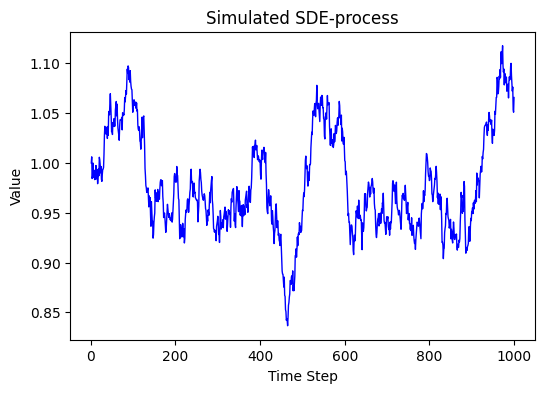

In [3]:
sde_data = euler_maruyama(n_samples = 1000, delta_t = 0.001, a = a, b = b, X0 = 1)
sde_data = np.array([np.arange(1,len(sde_data)+1),sde_data])
plt.figure(figsize=(6,4))
plt.plot(sde_data[0], sde_data[1], linewidth = 1, color ='blue')
plt.title("Simulated SDE-process")
plt.ylabel("Value")
plt.xlabel("Time Step")
plt.show()

### Geometric Brownian Motion

$dS_t = \mu S_tdt + \sigma S_tdW_t \\$

$S_0$: Initial Stock price $\\$
$\mu$: Drift coefficient $\\$
$\sigma$: Volatility coefficient $\\$
$W_t$: Wiener Process (Brownian motion)

In [2]:
import jax.numpy as jnp
from jax import random

def gbm_simulator(key, S0, mu, sigma, T, dt):

    # Number of time steps
    N = int(T / dt)
    t = jnp.linspace(0, T, N)
    W = random.normal(key, (N,)) * jnp.sqrt(dt)
    
    # Wiener process
    W = jnp.cumsum(W)
    S = S0 * jnp.exp((mu - 0.5 * sigma**2) * t + sigma * W)
    return S

# Parameters for the GBM
S0 = 100.0                  # Initial stock price
mu = 0.1                    # Drift coefficient
sigma = 0.2                 # Volatility coefficient
T = 5.0                     # Total time (year)
dt = 0.005                  # Time step

# Generate random key
key = random.PRNGKey(0)

# Simulate GBM
GBM_data = gbm_simulator(key, S0, mu, sigma, T, dt)

Validation data:

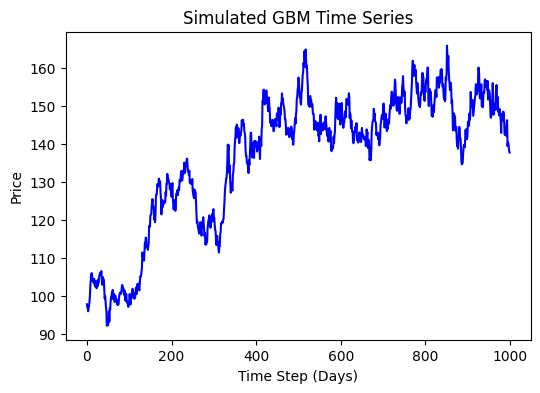

Mean Price: 136.36
Standard Deviation of Price: 17.87


In [3]:
def validate_simulated_data(simulated_data):

    # Plot the time series
    plt.figure(figsize=(6, 4))
    plt.plot(GBM_data, color ='blue')
    plt.title('Simulated GBM Time Series')
    plt.xlabel('Time Step (Days)')
    plt.ylabel('Price')
    plt.show()

    # Calculate and print basic statistics
    mean_price = jnp.mean(simulated_data)
    std_dev_price = jnp.std(simulated_data)
    print(f"Mean Price: {mean_price:.2f}")
    print(f"Standard Deviation of Price: {std_dev_price:.2f}")

# Validate the simulated data
validate_simulated_data(GBM_data)


#### Preprocess the data

In [4]:
# Length of the sequences to be used for prediction
input_seq = 50
output_seq = 10

# Generate sequences and targets
def create_sequences(data, input_seq, output_seq, step=output_seq):
    sequences = []
    targets = []
    for i in range(0, len(data) - input_seq - output_seq + 1, output_seq):
        sequences.append(data[i:i + input_seq])
        targets.append(data[i + input_seq:i + input_seq + output_seq])
    return np.array(sequences), np.array(targets)

x, y = create_sequences(GBM_data, input_seq, output_seq)

# Convert to JAX arrays
# x = jnp.array(x)
# y = jnp.array(y).reshape(-1, 1)

# Split the data into training and validation sets
train_size = int(len(x) * 0.8)
train_states = x[:train_size]
train_actions = y[:train_size]
val_states = x[train_size:]
val_actions = y[train_size:]

# Compute mean and standard deviation on the training data
mean = np.mean(train_states)
std = np.std(train_states)

# Normalize the data
train_states = (train_states - mean) / std
train_actions = (train_actions - mean) / std
val_states = (val_states - mean) / std
val_actions = (val_actions - mean) / std

print("Train sequences shape:", train_states.shape)
print("Train actions shape:", train_actions.shape)
print("Validation sequences shape:", val_states.shape)
print("Validation actions shape:", val_actions.shape)

Train sequences shape: (76, 50)
Train actions shape: (76, 10)
Validation sequences shape: (19, 50)
Validation actions shape: (19, 10)


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import random

# Ensure states have shape [num_sequences, sequence_length, num_features]
# In this case, sequence_length = 20 and num_features = 1
# From (784, 20) to (784, 20, 1) adding a dimension for the LSTM
train_states = train_states.reshape(-1, input_seq, 1)
val_states = val_states.reshape(-1, input_seq, 1)
train_actions = train_actions.reshape(-1, output_seq, 1)
val_actions = val_actions.reshape(-1, output_seq, 1)

# Convert the data to PyTorch tensors
train_states_tensor = torch.tensor(train_states, dtype=torch.float32)
train_actions_tensor = torch.tensor(train_actions, dtype=torch.float32)
val_states_tensor = torch.tensor(val_states, dtype=torch.float32)
val_actions_tensor = torch.tensor(val_actions, dtype=torch.float32)

# Create TensorDatasets
train_dataset = TensorDataset(train_states_tensor, train_actions_tensor)
val_dataset = TensorDataset(val_states_tensor, val_actions_tensor)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Verify DataLoader batch shapes
for batch in train_loader:
    inputs, targets = batch
    # Should be (batch_size, 20, 1)
    print("Batch input shape:", inputs.shape)
    # Should be (batch_size, 1)
    print("Batch target shape:", targets.shape)
    break


Batch input shape: torch.Size([32, 50, 1])
Batch target shape: torch.Size([32, 10, 1])


### LSTM Framework for pre-training the policy network

In [6]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(Encoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

    def forward(self, x):
        outputs, (hidden, cell) = self.lstm(x)
        return hidden, cell

class Decoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, num_layers):
        super(Decoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(output_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, hidden, cell):
        outputs, (hidden, cell) = self.lstm(x, (hidden, cell))
        predictions = self.fc(outputs)
        return predictions, hidden, cell

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, trg=None, teacher_forcing_ratio=0.5):
        batch_size = src.size(0)
        trg_len = trg.size(1) if trg is not None else src.size(1)
        trg_dim = src.size(2)
        
        outputs = torch.zeros(batch_size, trg_len, trg_dim).to(src.device)
        
        hidden, cell = self.encoder(src)
        
        # First input to the decoder
        if trg is not None:
            input = trg[:, 0, :].unsqueeze(1)  # Use the first target value during training
        else:
            input = src[:, -1, :].unsqueeze(1)  # Use the last input value during inference

        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[:, t, :] = output.squeeze(1)
            teacher_force = random.random() < teacher_forcing_ratio if trg is not None else False
            input = trg[:, t, :].unsqueeze(1) if teacher_force else output
        
        return outputs

# Define the model parameters
input_dim = 1  # Number of features in the input sequence
output_dim = 1  # Number of features in the output sequence
hidden_dim = 64
num_layers = 2

# Instantiate the encoder, decoder, and Seq2Seq model
encoder = Encoder(input_dim, hidden_dim, num_layers)
decoder = Decoder(output_dim, hidden_dim, num_layers)
model = Seq2Seq(encoder, decoder)

# Print the model architecture
print(model)
# Check initial values of the sequences
print("Initial values of input sequences:", train_states[:, 0, 0])
print("Initial values of target sequences:", train_actions[:, 0, 0])

Seq2Seq(
  (encoder): Encoder(
    (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  )
  (decoder): Decoder(
    (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
    (fc): Linear(in_features=64, out_features=1, bias=True)
  )
)


Loss function, optimizer and training

In [7]:
# Define the loss function
loss_fn = nn.MSELoss()

# Define the optimizer
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Example to show the setup
print("Loss function:", loss_fn)
print("Optimizer:", optimizer)

def train_model(model, train_loader, val_loader, loss_fn, optimizer, num_epochs, teacher_forcing_ratio=0.5):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            # Set the gradients to zero
            optimizer.zero_grad()
            # Forward pass with the predicted outputs
            outputs = model(inputs, targets, teacher_forcing_ratio)
            # Compute the loss
            loss = loss_fn(outputs, targets)
            # Backward pass (compute the gradients) and optimize the weights
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs, targets, teacher_forcing_ratio=0)  # No teacher forcing during validation
                loss = loss_fn(outputs, targets)
                val_loss += loss.item() * inputs.size(0)
        
        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}")
    
    return train_losses, val_losses


Loss function: MSELoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


### COULD USE CROSS VALIDATION TO FIND BEST PARAMETERS?

Training

In [8]:
# Parameters
num_epochs = 50  # Number of epochs for training

# Train the model and track losses
train_losses, val_losses = train_model(model, train_loader, val_loader, loss_fn, optimizer, num_epochs)

# Save the trained model
#torch.save(model.state_dict(), 'lstm_model.pth')

# Load the trained model for inference or further training
# model.load_state_dict(torch.load('lstm_model.pth'))

Epoch 1/50, Training Loss: 0.9128, Validation Loss: 0.8375
Epoch 2/50, Training Loss: 0.8876, Validation Loss: 0.8252
Epoch 3/50, Training Loss: 0.8596, Validation Loss: 0.7901
Epoch 4/50, Training Loss: 0.8020, Validation Loss: 0.7173
Epoch 5/50, Training Loss: 0.7181, Validation Loss: 0.6128
Epoch 6/50, Training Loss: 0.5936, Validation Loss: 0.4443
Epoch 7/50, Training Loss: 0.4060, Validation Loss: 0.2324
Epoch 8/50, Training Loss: 0.1995, Validation Loss: 0.2595
Epoch 9/50, Training Loss: 0.3294, Validation Loss: 0.2349
Epoch 10/50, Training Loss: 0.2103, Validation Loss: 0.2005
Epoch 11/50, Training Loss: 0.1883, Validation Loss: 0.2302
Epoch 12/50, Training Loss: 0.2019, Validation Loss: 0.2647
Epoch 13/50, Training Loss: 0.2026, Validation Loss: 0.2694
Epoch 14/50, Training Loss: 0.1885, Validation Loss: 0.2323
Epoch 15/50, Training Loss: 0.1741, Validation Loss: 0.1992
Epoch 16/50, Training Loss: 0.1721, Validation Loss: 0.1953
Epoch 17/50, Training Loss: 0.1721, Validation Lo

### Evaluation of the model

Training loss vs. validation loss

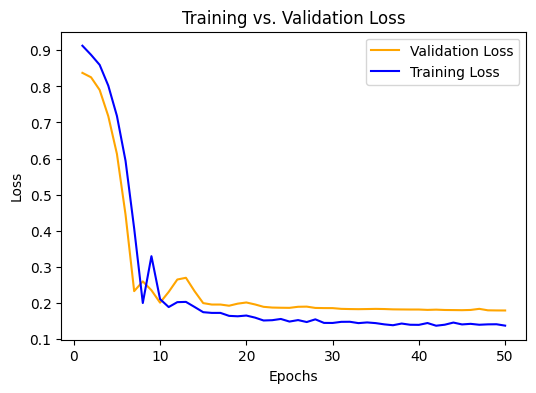

In [9]:
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', color =  'orange')
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', color = 'blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.show()


Evaluating the trajectory

In [10]:
model.eval()  # Set the model to evaluation mode

predictions = []
actuals = []

with torch.no_grad():
    for inputs, targets in val_loader:
        outputs = model(inputs, targets, teacher_forcing_ratio=0)  # No teacher forcing during prediction
        predictions.append(outputs.cpu().numpy())
        actuals.append(targets.cpu().numpy())

# Concatenate all batches
predictions = np.concatenate(predictions, axis=0)
actuals = np.concatenate(actuals, axis=0)

# Denormalize the predictions and actuals
denormalized_predictions = (predictions * std) + mean
denormalized_actuals = (actuals * std) + mean

In [12]:
denormalized_predictions[0:10]

array([[[133.20059],
        [153.52728],
        [153.58075],
        [153.36647],
        [153.12932],
        [152.94423],
        [152.81049],
        [152.7118 ],
        [152.63301],
        [152.56378]],

       [[133.20059],
        [149.6661 ],
        [149.79666],
        [149.68195],
        [149.54291],
        [149.44275],
        [149.3821 ],
        [149.34753],
        [149.32645],
        [149.31044]],

       [[133.20059],
        [152.84854],
        [153.2051 ],
        [153.18353],
        [153.05853],
        [152.9338 ],
        [152.83047],
        [152.74597],
        [152.673  ],
        [152.60559]],

       [[133.20059],
        [155.02602],
        [155.08606],
        [154.87321],
        [154.62048],
        [154.41034],
        [154.24669],
        [154.11635],
        [154.00581],
        [153.90562]],

       [[133.20059],
        [153.22334],
        [153.58328],
        [153.54771],
        [153.40717],
        [153.26918],
        [153.15504],
     

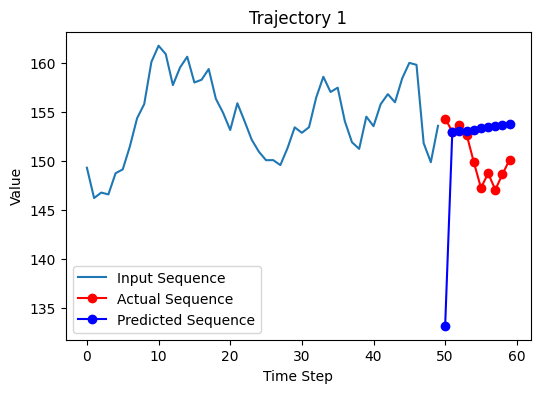

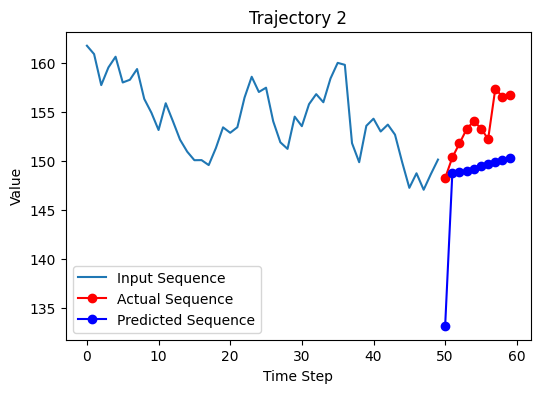

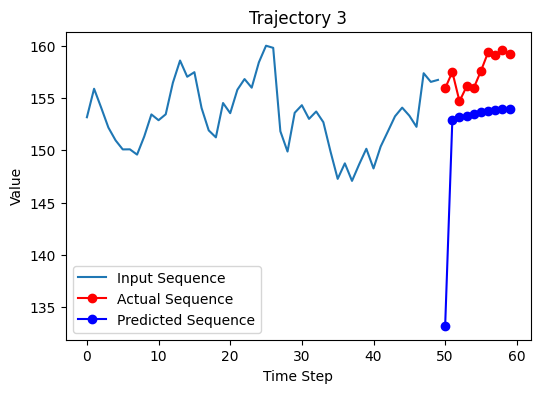

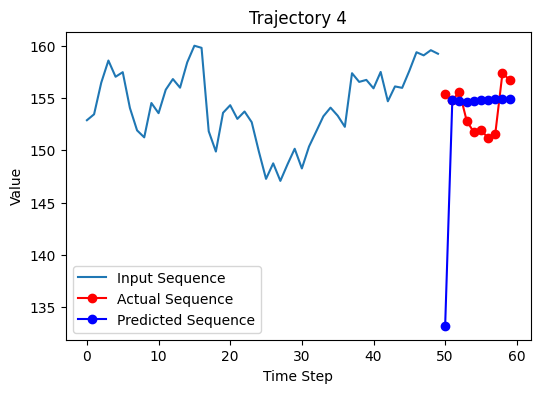

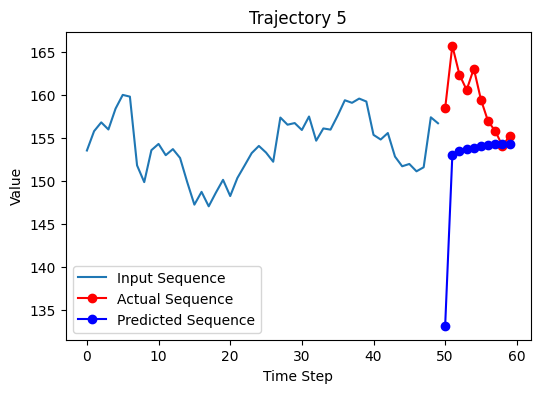

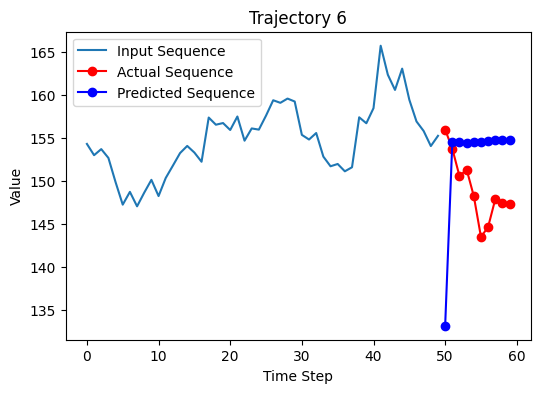

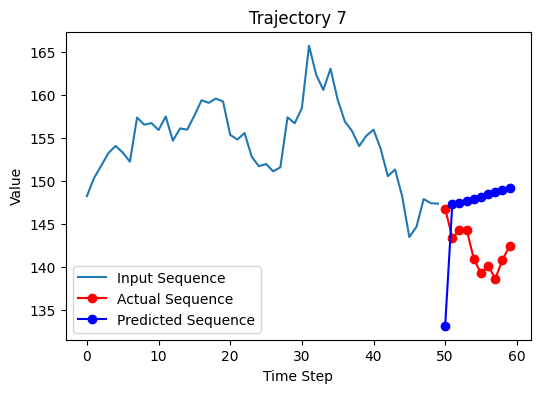

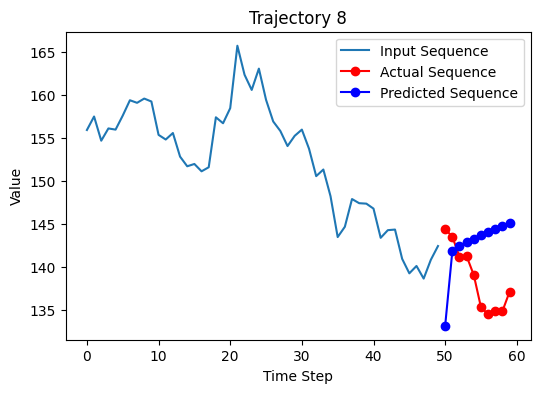

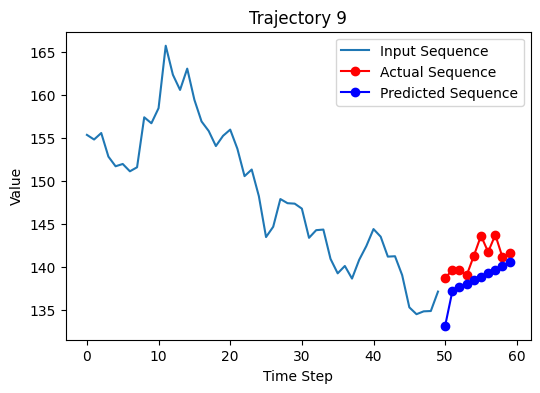

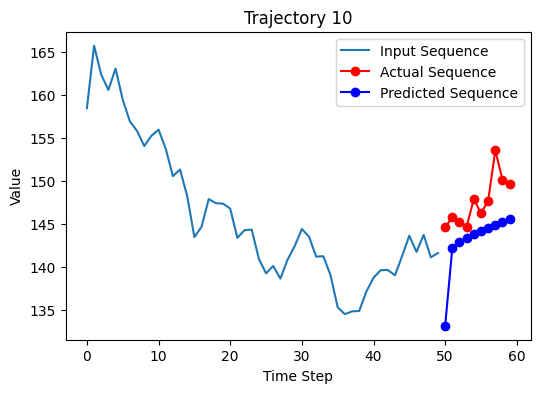

In [49]:
# Number of sequences to plot
num_plots = 10

for i in range(num_plots):
    plt.figure(figsize=(6, 4))
    plt.plot(range(input_seq), val_states[i] * std + mean, label='Input Sequence')
    plt.plot(range(input_seq, input_seq + output_seq), denormalized_actuals[i], 'ro-', label='Actual Sequence')
    plt.plot(range(input_seq, input_seq + output_seq), denormalized_predictions[i], 'bo-', label='Predicted Sequence')
    plt.legend()
    plt.title(f'Trajectory {i+1}')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.show()

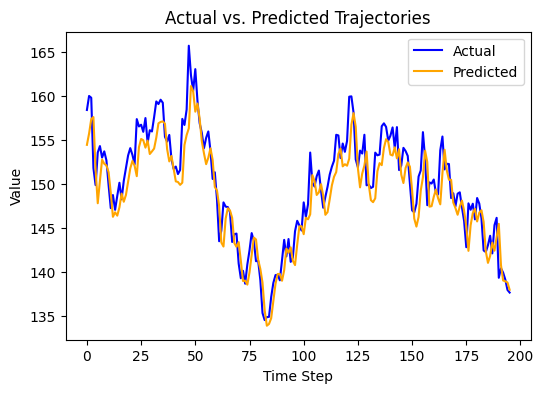

In [10]:
# Ensure the model is in evaluation mode
model.eval()

# Generate predictions for the validation set
with torch.no_grad():
    predictions = model(val_states_tensor)

denormalized_predictions = predictions.numpy() * std + mean
denormalized_actuals = val_actions_tensor.numpy() * std + mean

# Plot actual vs. predicted trajectories
plt.figure(figsize=(6, 4))
plt.plot(denormalized_actuals, label='Actual', color = "blue")
plt.plot(denormalized_predictions, label='Predicted', color = "orange")
plt.title('Actual vs. Predicted Trajectories')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

Mean, Standard Deviation, Skewness, Kurtosis of the data

$MAE = \frac{1}{n} \sum_{n=1}^{n} |y_i-\^y_i|$ $\\$
$RSME \sqrt{\frac{1}{n} \sum_{n=1}^{n} (y_i-\^y_i)^2}$ $\\$
$R^2 = 1 - \frac{\sum_{n=1}^{n} (y_i-\^y_i)^2}{\sum_{n=1}^{n} (y_i-\bar{y})^2}$

In [11]:
from scipy.stats import skew, kurtosis
from tabulate import tabulate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

actual_mean = np.mean(denormalized_actuals)
predicted_mean = np.mean(denormalized_predictions)
actual_std = np.std(denormalized_actuals)
predicted_std = np.std(denormalized_predictions)
actual_skew = skew(denormalized_actuals)
predicted_skew = skew(denormalized_predictions)
actual_kurtosis = kurtosis(denormalized_actuals)
predicted_kurtosis = kurtosis(denormalized_predictions)

stats_data = [
    ['Mean', actual_mean, predicted_mean],
    ['Std', actual_std, predicted_std],
    ['Skewness', actual_skew, predicted_skew],
    ['Kurtosis', actual_kurtosis, predicted_kurtosis]
]
headers = ["Actual", "Predicted"]
print(tabulate(stats_data, headers=headers, tablefmt="grid"))

mae = mean_absolute_error(denormalized_actuals, denormalized_predictions)
rmse = np.sqrt(mean_squared_error(denormalized_actuals, denormalized_predictions))
r2 = r2_score(denormalized_actuals, denormalized_predictions)

more_stats_data = [
    ['MAE', mae],
    ['RMSE', rmse],
    ['R-squared', r2]
]
print(tabulate(more_stats_data, headers=["Metric", "Value"], tablefmt="grid"))

+----------+------------+-------------+
|          |     Actual |   Predicted |
+==========+============+=============+
| Mean     | 149.875    |  148.679    |
+----------+------------+-------------+
| Std      |   6.25819  |    5.58439  |
+----------+------------+-------------+
| Skewness |  -0.300999 |   -0.399394 |
+----------+------------+-------------+
| Kurtosis |  -0.414078 |   -0.347111 |
+----------+------------+-------------+
+-----------+----------+
| Metric    |    Value |
+===========+==========+
| MAE       | 2.11508  |
+-----------+----------+
| RMSE      | 2.67305  |
+-----------+----------+
| R-squared | 0.817561 |
+-----------+----------+


Autocorrelation and Partial Autocorrelation:

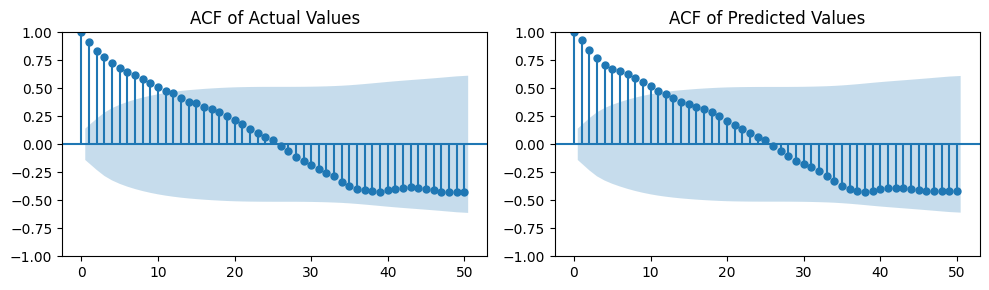

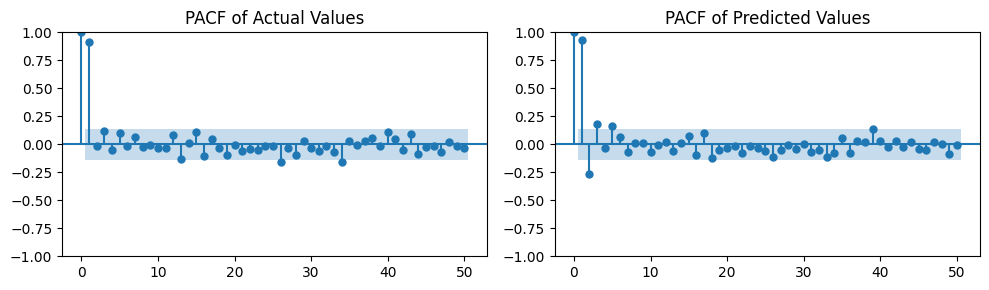

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Calculate the residuals (errors)
residuals = denormalized_actuals - denormalized_predictions

# Plot ACF
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

plot_acf(denormalized_actuals, ax=axes[0], lags=50)
axes[0].set_title('ACF of Actual Values')
plot_acf(denormalized_predictions, ax=axes[1], lags=50)
axes[1].set_title('ACF of Predicted Values')

plt.tight_layout()
plt.show()

# Plot PACF
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

plot_pacf(denormalized_actuals, ax=axes[0], lags=50)
axes[0].set_title('PACF of Actual Values')
plot_pacf(denormalized_predictions, ax=axes[1], lags=50)
axes[1].set_title('PACF of Predicted Values')

plt.tight_layout()
plt.show()

### Did not work...

In [ ]:
# Define LSTM model
class LSTMModel(hk.Module):
    def __init__(self, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size

    def __call__(self, x):
        lstm = hk.LSTM(self.hidden_size)
        output, state = hk.dynamic_unroll(lstm, x, lstm.initial_state(x.shape[0]))
        output = hk.Linear(self.output_size)(output)
        return output

def forward_fn(x):
    model = LSTMModel(hidden_size=64, output_size=1)  # Adjust hidden size and output size as needed
    return model(x)

# Transform the forward function
forward = hk.transform(forward_fn)

# Initialize the model parameters
rng = jax.random.PRNGKey(42)
sample_input = jnp.ones((10, 50, 1))  # Example input: batch of 10 sequences, each of length 50, with 1 feature per timestep
params = forward.init(rng, sample_input)

# Print the initialized parameters
print("Initialized parameters:", params)

In [ ]:
import jax
import jax.numpy as jnp
from flax import linen as nn
from flax.training import train_state
import optax

# Define the LSTM model
class LSTMModel(nn.Module):
    hidden_size: int
    output_size: int

    @nn.compact
    def __call__(self, x):
        # Initialize LSTM cell
        lstm = nn.LSTMCell()
        initial_carry = lstm.initialize_carry(jax.random.PRNGKey(0), (x.shape[0],), self.hidden_size)

        # Apply LSTM over the sequence
        carry = initial_carry
        outputs = []
        for t in range(x.shape[1]):
            carry, y = lstm(carry, x[:, t])
            outputs.append(y)
        output = outputs[-1]

        # Final linear layer to produce output
        output = nn.Dense(self.output_size)(output)
        return output

# Initialize the model
def create_model(rng, input_shape, hidden_size, output_size):
    model = LSTMModel(hidden_size=hidden_size, output_size=output_size)
    params = model.init(rng, jnp.ones(input_shape))
    return model, params

# Example usage
rng = jax.random.PRNGKey(42)
input_shape = (32, 50, 1)  # Example input: batch of 32 sequences, each of length 50, with 1 feature per timestep
hidden_size = 64
output_size = 1

model, params = create_model(rng, input_shape, hidden_size, output_size)

# Print the initialized parameters
print("Initialized parameters:", params)

### Preprocess Data (Creating State-Action pairs)

- **State:** Window of consequtive values from time series.
- **Action:** Next value in the time series.

- **Window size:** 10

In [4]:
def state_action_pairs(data, window):
    states = []
    actions = []

    for i in range(len(data)-window):
        state = data[i:i+window]
        action = data[i+window]
        states.append(state)
        actions.append(action)
    
    return np.array(states), np.array(actions)

states, actions = state_action_pairs(sde_data[1], window=10)

# for i in range(3):
#     print(f"State {i}: {states[i]}")
#     print(f"Action {i}: {actions[i]}")
#     print("")

### S5 JAX framework to train the policy network

State Action Dataset

In [32]:
class StateActionDataset:
    def __init__(self, states, actions):
        self.states = states
        self.actions = actions

    def __len__(self):
        return len(self.states)

    def __getitem__(self, idx):
        return self.states[idx], self.actions[idx]


# Split data into training and validation sets
train_states, val_states, train_actions, val_actions = train_test_split(states, actions, test_size=0.2, random_state=42)

train_dataset = StateActionDataset(train_states, train_actions)
val_dataset = StateActionDataset(val_states, val_actions)

train_s = jnp.array(train_states)
train_a = jnp.array(train_actions)
val_s = jnp.array(val_states)
val_a = jnp.array(val_actions)

S5 Framework

In [33]:
# Define the S5 layer
class S5Layer(nn.Module):
    input_dim: int
    output_dim: int

    def setup(self):
        self.W = self.param('W', nn.initializers.xavier_uniform(), (self.input_dim, self.output_dim))
        self.b = self.param('b', nn.initializers.zeros, (self.output_dim,))

    # Forward pass of the layer
    def __call__(self, x):
        return jnp.dot(x, self.W) + self.b

# Define the S5 block
class S5Block(nn.Module):
    input_dim: int
    output_dim: int

    def setup(self):
        self.s5_layer = S5Layer(self.input_dim, self.output_dim)
        self.norm = nn.LayerNorm()
        self.dropout = nn.Dropout(0.1)

    def __call__(self, x, train: bool = True):
        x = self.s5_layer(x)
        x = jnn.relu(x)
        x = self.norm(x)
        x = self.dropout(x, deterministic=not train)
        return x

# Define the full S5 model
class S5Model(nn.Module):
    input_dim: int
    hidden_dim: int
    num_layers: int
    output_dim: int

    def setup(self):
        self.layers = [
            S5Block(self.input_dim if i == 0 else self.hidden_dim, 
                    self.output_dim if i == self.num_layers - 1 else self.hidden_dim) 
            for i in range(self.num_layers)
        ]

    def __call__(self, x, train: bool = True):
        for i, layer in enumerate(self.layers):
            #print(f"Shape before layer {i}: {x.shape}")
            x = layer(x, train)
            #print(f"Shape after layer {i}: {x.shape}")
        return x


In [34]:
# Initialize the model
input_dim = 10  # Number of features in state
hidden_dim = 10  # Ensure consistent hidden dimensions
output_dim = 1  # Number of features in action
num_layers = 3
model = S5Model(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers, output_dim=output_dim)

# Create a random input tensor for initialization
x = jnp.ones((1, input_dim))  # [batch_size, feature_dimension]

# Initialize parameters
rng = jax.random.PRNGKey(0)
# Extract 'params' correctly from 'variables'
variables = model.init(rng, x, train=True)
params = variables['params']

Training the policy network

In [35]:
# Define the loss function
def mse_loss(params, apply_fn, x, y, train: bool, rng=None):

    if train and rng is None:
        raise ValueError("RNG key must be provided for training with dropout")
    # Forward pass
    preds = apply_fn({'params': params}, x, rngs={'dropout': rng} if rng else {}, train=train)
    return jnp.mean((preds - y) ** 2)

@jax.jit
def train_step(state, x, y):
    def loss_fn(params):
        rng, rng_dropout = jax.random.split(state.rng)
        preds = state.apply_fn({'params': params}, x, rngs={'dropout': rng_dropout}, train=True)
        loss = jnp.mean((preds - y) ** 2)
        return loss, rng
    
    (loss, rng), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads).replace(rng=rng)
    return state, loss

def data_generator(states, actions, batch_size, sequence_length):
    num_samples = len(states) - sequence_length + 1
    for start_idx in range(0, num_samples, batch_size):
        end_idx = min(start_idx + batch_size, num_samples)
        batch_states = [states[i:i + sequence_length] for i in range(start_idx, end_idx)]
        batch_actions = [actions[i + sequence_length - 1] for i in range(start_idx, end_idx)]
        yield jnp.array(batch_states), jnp.array(batch_actions)

In [36]:

num_epochs = 500
batch_size = 32
sequence_length = 10

# Initialize the training state
class TrainState(train_state.TrainState):
    rng: jax.random.PRNGKey
rng = jax.random.PRNGKey(0)
tx = optax.adam(learning_rate=0.001)
state = TrainState.create(apply_fn=model.apply, params=params, tx=tx, rng=rng)

# Training step
for epoch in range(num_epochs):
    # Training
    for batch_states, batch_actions in data_generator(train_states, train_actions, batch_size, sequence_length):
        batch = (jnp.array(batch_states), jnp.array(batch_actions))
        state, loss = train_step(state, batch[0], batch[1])

    # Compute loss on validation set with train=False to disable dropout
    val_loss = mse_loss(state.params, state.apply_fn, jnp.array(val_states), jnp.array(val_actions), train=False)
    print(f'Epoch {epoch + 1}, Validation Loss: {val_loss:.4f}')
    
    # Optionally, print training loss for better insight
    print(f'Epoch {epoch + 1}, Training Loss: {loss:.4f}')

pretrained_params = state.params


Epoch 1, Validation Loss: 0.9085
Epoch 1, Training Loss: 0.8911
Epoch 2, Validation Loss: 0.8622
Epoch 2, Training Loss: 0.8457
Epoch 3, Validation Loss: 0.8176
Epoch 3, Training Loss: 0.7996
Epoch 4, Validation Loss: 0.7749
Epoch 4, Training Loss: 0.7595
Epoch 5, Validation Loss: 0.7341
Epoch 5, Training Loss: 0.7193
Epoch 6, Validation Loss: 0.6948
Epoch 6, Training Loss: 0.6846
Epoch 7, Validation Loss: 0.6574
Epoch 7, Training Loss: 0.6530
Epoch 8, Validation Loss: 0.6217
Epoch 8, Training Loss: 0.6121
Epoch 9, Validation Loss: 0.5875
Epoch 9, Training Loss: 0.5765
Epoch 10, Validation Loss: 0.5547
Epoch 10, Training Loss: 0.5421
Epoch 11, Validation Loss: 0.5234
Epoch 11, Training Loss: 0.5429
Epoch 12, Validation Loss: 0.4937
Epoch 12, Training Loss: 0.4867
Epoch 13, Validation Loss: 0.4653
Epoch 13, Training Loss: 0.4597
Epoch 14, Validation Loss: 0.4382
Epoch 14, Training Loss: 0.4304
Epoch 15, Validation Loss: 0.4124
Epoch 15, Training Loss: 0.4371
Epoch 16, Validation Loss: 0

In [37]:
class Discriminator(nn.Module):
    input_dim: int
    hidden_dim: int
    output_dim: int = 1

    def setup(self):
        self.dense1 = nn.Dense(self.hidden_dim)
        self.dense2 = nn.Dense(self.hidden_dim)
        self.dense3 = nn.Dense(self.output_dim)

    def __call__(self, x):
        x = nn.relu(self.dense1(x))
        x = nn.relu(self.dense2(x))
        x = nn.sigmoid(self.dense3(x))
        return x

# Initialize the discriminator
discriminator = Discriminator(input_dim=input_dim, hidden_dim=hidden_dim)


In [38]:
def discriminator_loss(discriminator_params, policy_params, real_data, fake_data, apply_fn):
    real_preds = apply_fn({'params': discriminator_params}, real_data)
    fake_preds = apply_fn({'params': discriminator_params}, fake_data)
    real_loss = optax.sigmoid_binary_cross_entropy(real_preds, jnp.ones_like(real_preds))
    fake_loss = optax.sigmoid_binary_cross_entropy(fake_preds, jnp.zeros_like(fake_preds))
    return jnp.mean(real_loss + fake_loss)

def policy_loss(policy_params, discriminator_params, state_data, apply_fn_policy, apply_fn_discriminator, rng):
    actions = apply_fn_policy({'params': policy_params}, state_data, rngs={'dropout': rng}, train=True)
    preds = apply_fn_discriminator({'params': discriminator_params}, actions)
    return jnp.mean(optax.sigmoid_binary_cross_entropy(preds, jnp.ones_like(preds)))


In [39]:
@jax.jit
def update_discriminator(state_discriminator, state_policy, real_data, fake_data):
    def loss_fn(discriminator_params):
        return discriminator_loss(discriminator_params, state_policy.params, real_data, fake_data, state_discriminator.apply_fn)
    
    grads = jax.grad(loss_fn)(state_discriminator.params)
    state_discriminator = state_discriminator.apply_gradients(grads=grads)
    return state_discriminator

@jax.jit
def update_policy(state_policy, state_discriminator, state_data, rng):
    def loss_fn(policy_params):
        return policy_loss(policy_params, state_discriminator.params, state_data, state_policy.apply_fn, state_discriminator.apply_fn, rng)
    
    loss, grads = jax.value_and_grad(loss_fn)(state_policy.params)
    state_policy = state_policy.apply_gradients(grads=grads)
    return state_policy, loss


In [40]:
# Initialize the training states for both policy and discriminator
tx = optax.adam(learning_rate=0.001)

# Initialize discriminator parameters
rng = jax.random.PRNGKey(1)
discriminator_params = discriminator.init(rng, jnp.ones((1, input_dim)))['params']
state_discriminator = TrainState.create(apply_fn=discriminator.apply, params=discriminator_params, tx=tx, rng=rng)

# Use pretrained params for policy network
rng = jax.random.PRNGKey(0)
state_policy = TrainState.create(apply_fn=model.apply, params=pretrained_params, tx=tx, rng=rng)


In [ ]:
num_epochs = 100
batch_size = 32
sequence_length = 10

for epoch in range(num_epochs):
    for real_data, state_data in data_generator(train_s, train_a, batch_size, sequence_length):
        fake_data = state_policy.apply_fn({'params': state_policy.params}, jnp.array(state_data), rngs={'dropout': state_policy.rng}, train=True)
        
        # Update discriminator
        state_discriminator = update_discriminator(state_discriminator, state_policy, jnp.array(real_data), fake_data)
        
        # Update policy
        state_policy, policy_loss_value = update_policy(state_policy, state_discriminator, jnp.array(state_data), state_policy.rng)
    
    # Compute validation loss and other metrics as needed
    val_loss = mse_loss(state_policy.params, state_policy.apply_fn, jnp.array(val_states), jnp.array(val_actions), train=False)
    print(f'Epoch {epoch + 1}, Validation Loss: {val_loss:.4f}, Policy Loss: {policy_loss_value:.4f}')
